In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Set a consistent style for plots
sns.set_theme(style="whitegrid")

# Load dataset
# Replace `your_dataset.csv` with the actual dataset path
data=pd.read_csv('C:\\Users\\omarbayom\\Desktop\\ML\\project\\Heart-Failure-Prediction\\Dataset\\heart.csv')

# Display the first few rows of the dataset
data.head()


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
from sklearn.preprocessing import LabelEncoder

# Columns to be label encoded
columns_to_encode = ["RestingECG", 'ExerciseAngina', 'ST_Slope', 'Sex', 'ChestPainType']

# Initialize the label encoder
label_encoder = LabelEncoder()

# Apply label encoding to each column
for column in columns_to_encode:
    data[column] = label_encoder.fit_transform(data[column])

data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0


In [4]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define a mask to filter out the outliers
mask = ~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)

# Apply the mask to the dataframe
data = data[mask]

data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
4,54,1,2,150,195,0,1,122,0,0.0,2,0
5,39,1,2,120,339,0,1,170,0,0.0,2,0
7,54,1,1,110,208,0,1,142,0,0.0,2,0
8,37,1,0,140,207,0,1,130,1,1.5,1,1


In [5]:

X = data.drop('HeartDisease', axis=1)  
y = data['HeartDisease']


In [6]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [7]:
X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)
print(f"Training Set: {X_train.shape}, Validation Set: {X_val.shape}, Testing Set: {X_test.shape}")

Training Set: (166, 11), Validation Set: (56, 11), Testing Set: (56, 11)


In [8]:
nb_model = GaussianNB()

# Define hyperparameter configurations
param_grid = {
    'var_smoothing': np.logspace(-9, 0, 50)  # Example parameter grid
}

# Perform grid search for hyperparameter tuning
grid_search = GridSearchCV(nb_model, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e-09, 1.52641797e-09, 2.32995181e-09, 3.55648031e-09,
       5.42867544e-09, 8.28642773e-09, 1.26485522e-08, 1.93069773e-08,
       2.94705170e-08, 4.49843267e-08, 6.86648845e-08, 1.04811313e-07,
       1.59985872e-07, 2.44205309e-07, 3.72759372e-07, 5.68986603e-07,
       8.68511374e-07, 1.32571137e-06, 2.02...
       1.38949549e-04, 2.12095089e-04, 3.23745754e-04, 4.94171336e-04,
       7.54312006e-04, 1.15139540e-03, 1.75751062e-03, 2.68269580e-03,
       4.09491506e-03, 6.25055193e-03, 9.54095476e-03, 1.45634848e-02,
       2.22299648e-02, 3.39322177e-02, 5.17947468e-02, 7.90604321e-02,
       1.20679264e-01, 1.84206997e-01, 2.81176870e-01, 4.29193426e-01,
       6.55128557e-01, 1.00000000e+00])},
             scoring='accuracy', verbose=1)

In [9]:
best_params = grid_search.best_params_
train_accuracy = grid_search.best_score_
val_accuracy = grid_search.score(X_val, y_val)

In [10]:
print(f"Best Parameters: {best_params}")
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Validation Accuracy: {val_accuracy:.2f}")

Best Parameters: {'var_smoothing': 1e-09}
Training Accuracy: 0.86
Validation Accuracy: 0.80


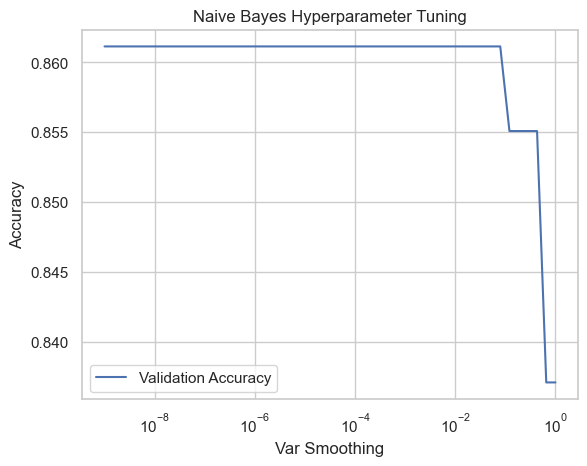

In [11]:
results = pd.DataFrame(grid_search.cv_results_)
plt.plot(results['param_var_smoothing'], results['mean_test_score'], label="Validation Accuracy")
plt.xscale('log')
plt.xlabel('Var Smoothing')
plt.ylabel('Accuracy')
plt.title('Naive Bayes Hyperparameter Tuning')
plt.legend()
plt.show()

In [12]:
y_test_pred = grid_search.predict(X_test)

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average='weighted')
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

In [13]:
print(f"Test Set Metrics:")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Test Set Metrics:
Precision: 0.86
Recall: 0.84
F1-Score: 0.84


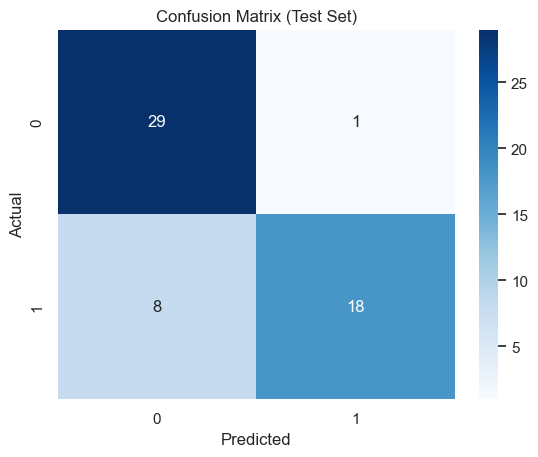

In [14]:
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [15]:
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))


Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.78      0.97      0.87        30
           1       0.95      0.69      0.80        26

    accuracy                           0.84        56
   macro avg       0.87      0.83      0.83        56
weighted avg       0.86      0.84      0.84        56



In [16]:
linkage_matrix = linkage(X_scaled, method='ward')

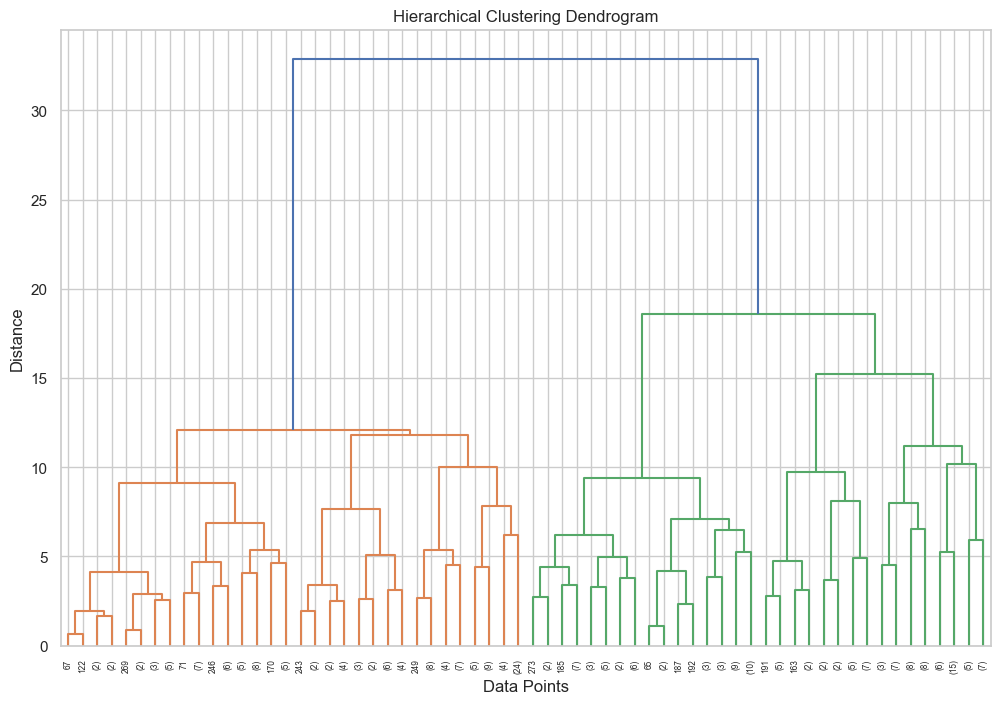

In [17]:
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

In [18]:
print("From the dendrogram, identify the optimal number of clusters based on the largest vertical distance between merges.")

From the dendrogram, identify the optimal number of clusters based on the largest vertical distance between merges.


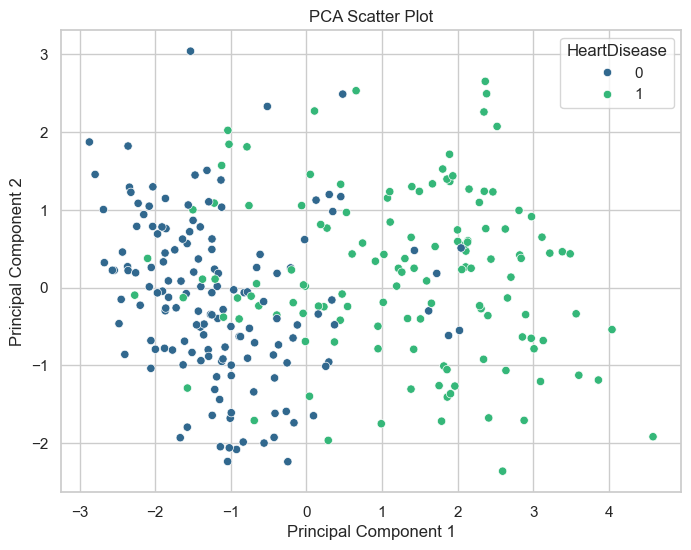

In [19]:
# Perform PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Scatter plot of PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='viridis')
plt.title("PCA Scatter Plot")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()